<a href="https://colab.research.google.com/github/twishi03/liver/blob/master/WSI_Loading_Cropping_Tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load WSI svs and cropping tiles
!apt update && apt install -y openslide-tools
!pip install openslide-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openslide-python: filename=openslide_python-1.3.0-cp310-cp310-linux_x86_64.whl size=33546 sha256=70c3d195e90b5a89eb8718faa672d553aa07932343d6c579410bc0eb20cb6c16
  Stored in directory: /root/.cache/pip/wheels/4d/a0/e6/e94ffceb76b28f1be2f59303ad58fdcf11822caa64960ed352
Successfully built openslide-python


In [5]:
from openslide import open_slide
import openslide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


In [84]:
 #Load the slide file (svs) into an object.
slide = open_slide("/content/GTEX-1LSNM-0526.svs")

In [85]:
slide_props = slide.properties
print(slide_props)

print("Vendor is:", slide_props['openslide.vendor'])
print("Pixel size of X in um is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in um is:", slide_props['openslide.mpp-y'])

<_PropertyMap {'aperio.AppMag': '20', 'aperio.DSR ID': 'vaiaperio03', 'aperio.Date': '05/01/15', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': '83831', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '83831', 'aperio.Left': '14.624326', 'aperio.LineAreaXOffset': '0.023001', 'aperio.LineAreaYOffset': '-0.006920', 'aperio.LineCameraSkew': '0.001659', 'aperio.MPP': '0.4942', 'aperio.OriginalHeight': '22667', 'aperio.OriginalWidth': '40640', 'aperio.ScanScope ID': 'SS1553', 'aperio.StripeWidth': '2032', 'aperio.Time': '14:40:16', 'aperio.Time Zone': 'GMT-04:00', 'aperio.Top': '17.473372', 'aperio.User': '72d07734-9fbe-4dbf-a3a2-e6427426477f', 'openslide.comment': 'Aperio Image Library v12.0.11 \r\n40640x22667 [0,100 39839x22567] (240x240) JPEG/RGB Q=70|AppMag = 20|StripeWidth = 2032|ScanScope ID = SS1553|Filename = 83831|Date = 05/01/15|Time = 14:40:16|Time Zone = GMT-04:00|User

In [86]:
#Objective used to capture the image
objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print("The objective power is: ", objective)

The objective power is:  20.0


In [87]:
# get slide dimensions for the level 0 - max resolution level
slide_dims = slide.dimensions
print(slide_dims)

(39839, 22567)


In [88]:
#Get a thumbnail of the image and visualize
slide_thumb_600 = slide.get_thumbnail(size=(600, 600))
slide_thumb_600.show()

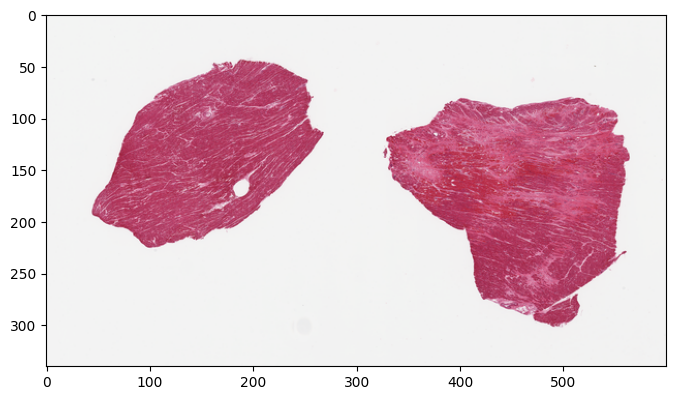

In [89]:
#Convert thumbnail to numpy array
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_600_np)

In [90]:
#Get slide dims at each level. Remember that whole slide images store information
#as pyramid at various levels
dims = slide.level_dimensions

In [91]:
num_levels = len(dims)
print("Number of levels in this image are:", num_levels)

print("Dimensions of various levels in this image are:", dims)

Number of levels in this image are: 3
Dimensions of various levels in this image are: ((39839, 22567), (9959, 5641), (2489, 1410))


In [92]:
#By how much are levels downsampled from the original image?
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors)

Each level is downsampled by an amount of:  (1.0, 4.000416527831473, 16.005495527840225)


In [93]:
#Copy an image from a level
level3_dim = dims[2]
#Give pixel coordinates (top left pixel in the original large image)
#Also give the level number (for level 3 we are providing a valueof 2)
#Size of your output image
#Remember that the output would be a RGBA image (Not, RGB)
level3_img = slide.read_region((0,0), 2, level3_dim) #Pillow object, mode=RGBA

In [94]:
#Convert the image to RGB
level3_img_RGB = level3_img.convert('RGB')
level3_img_RGB.show()

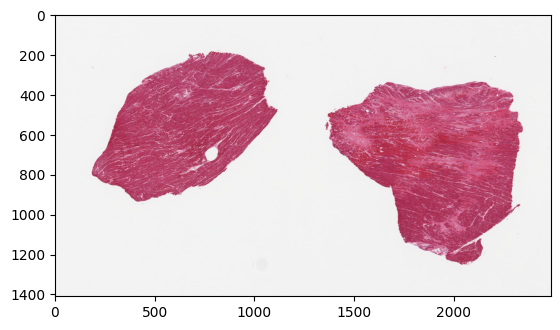

In [95]:
#Convert the image into numpy array for processing
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)

In [96]:
#Return the best level for displaying the given downsample.
SCALE_FACTOR = 32
best_level = slide.get_best_level_for_downsample(SCALE_FACTOR)

In [97]:
#Generating tiles for deep learning training or other processing purposes
#We can use read_region function and slide over the large image to extract tiles
#but an easier approach would be to use DeepZoom based generator.
# https://openslide.org/api/python/

from openslide.deepzoom import DeepZoomGenerator

In [98]:
#Generate object for tiles using the DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)

In [99]:
#Here, we have divided our svs into tiles of size 256 with no overlap.

#The tiles object also contains data at many levels.
#To check the number of levels
print("The number of levels in the tiles object are: ", tiles.level_count)

print("The dimensions of data in each level are: ", tiles.level_dimensions)

The number of levels in the tiles object are:  17
The dimensions of data in each level are:  ((1, 1), (2, 1), (3, 2), (5, 3), (10, 6), (20, 12), (39, 23), (78, 45), (156, 89), (312, 177), (623, 353), (1245, 706), (2490, 1411), (4980, 2821), (9960, 5642), (19920, 11284), (39839, 22567))


In [100]:
#Total number of tiles in the tiles object
print("Total number of tiles = : ", tiles.tile_count)

Total number of tiles = :  18623


In [101]:
#How many tiles at a specific level?
level_num = 11
print("Tiles shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], " total tiles in this level")


Tiles shape at level  11  is:  (5, 3)
This means there are  15  total tiles in this level


In [102]:
#Dimensions of the tile (tile size) for a specific tile from a specific layer
tile_dims = tiles.get_tile_dimensions(15, (5,3)) #Provide deep zoom level and address (column, row)

In [103]:
#Tile count at the highest resolution level (level 16 in our tiles)
tile_count_in_large_image = tiles.level_tiles[15] #126 x 151 (32001/256 = 126 with no overlap pixels)

In [104]:
single_tile = tiles.get_tile(16, (19, 34)) #Provide deep zoom level and address (column, row)
single_tile_RGB = single_tile.convert('RGB')
single_tile_RGB.show()

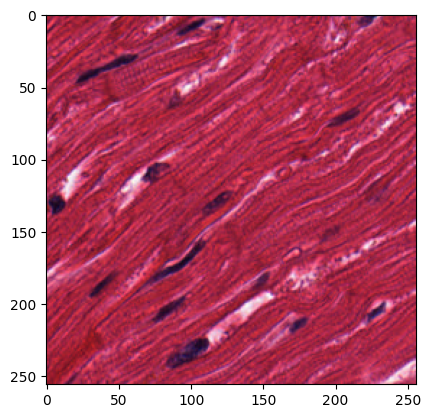

In [105]:
#Convert the image into numpy array for processing
level3_img_np = np.array(single_tile_RGB)
plt.imshow(single_tile_RGB)

In [106]:
###### Saving each tile to local directory
cols, rows = tiles.level_tiles[16]

In [52]:
import os
tile_dir = "/content/tiles"
for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".png", temp_tile_np)

Now saving tile with title:  /content/tiles/0_0
Now saving tile with title:  /content/tiles/1_0
Now saving tile with title:  /content/tiles/2_0
Now saving tile with title:  /content/tiles/3_0
Now saving tile with title:  /content/tiles/4_0
Now saving tile with title:  /content/tiles/5_0
Now saving tile with title:  /content/tiles/6_0
Now saving tile with title:  /content/tiles/7_0
Now saving tile with title:  /content/tiles/8_0
Now saving tile with title:  /content/tiles/9_0
Now saving tile with title:  /content/tiles/10_0
Now saving tile with title:  /content/tiles/11_0
Now saving tile with title:  /content/tiles/12_0
Now saving tile with title:  /content/tiles/13_0
Now saving tile with title:  /content/tiles/14_0
Now saving tile with title:  /content/tiles/15_0
Now saving tile with title:  /content/tiles/16_0
Now saving tile with title:  /content/tiles/17_0
Now saving tile with title:  /content/tiles/18_0
Now saving tile with title:  /content/tiles/19_0
Now saving tile with title:  /

In [ ]:
from google.colab import drive
drive.mount('/content/drive')